# Bayesian Zig Zag

Developing probabilistic models using grid methods and MCMC.

Thanks to Chris Fonnesback for his help with this notebook, and to Colin Carroll, who added features to pymc3 to support some of these examples.

Copyright 2018 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
%matplotlib inline
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

## Simulating hockey

I'll model hockey as a Poisson process, where each team has some long-term average scoring rate, `lambda`, in goals per game.

For the first example, I'll assume that `lambda` is somehow known to be 2.7.  Since regulation play (as opposed to overtime) is 60 minutes, we can compute the goal scoring rate per minute.

In [2]:
lam_per_game = 2.7
min_per_game = 60
lam_per_min = lam_per_game / min_per_game
lam_per_min, lam_per_min**2

(0.045000000000000005, 0.0020250000000000003)

If we assume that a goal is equally likely during any minute of the game, and we ignore the possibility of scoring more than one goal in the same minute, we can simulate a game by generating one random value each minute.

In [3]:
def simulate_game(p, n=60):
    goals = np.random.choice([0, 1], n, p=[1-p, p])
    return np.sum(goals)

And simulate 10 games.

In [4]:
size = 10
sample = [simulate_game(lam_per_min) for i in range(size)]

[1, 6, 2, 3, 0, 1, 3, 2, 2, 1]

If we simulate 1000 games, we can see what the distribution looks like.  The average of this sample should be close to `lam_per_game`.

In [5]:
size = 1000
sample_sim = [simulate_game(lam_per_min) for i in range(size)]
np.mean(sample_sim), lam_per_game

(2.706, 2.7)

## PMFs

To visualize distributions, I'll start with a probability mass function (PMF), which I'll implement using a `Counter`.



In [6]:
from collections import Counter

class Pmf(Counter):
    
    def normalize(self):
        """Normalizes the PMF so the probabilities add to 1."""
        total = sum(self.values())
        for key in self:
            self[key] /= total
            
    def sorted_items(self):
        """Returns the outcomes and their probabilities."""
        return zip(*sorted(self.items()))

Here are some functions for plotting PMFs.

In [7]:
plot_options = dict(linewidth=3, alpha=0.6)

def underride(options):
    """Add key-value pairs to d only if key is not in d.

    options: dictionary
    """

    for key, val in plot_options.items():
        options.setdefault(key, val)
    return options

def plot(xs, ys, **options):
    """Line plot with plot_options."""
    plt.plot(xs, ys, **underride(options))

def bar(xs, ys, **options):
    """Bar plot with plot_options."""
    plt.bar(xs, ys, **underride(options))

def plot_pmf(sample, **options):
    """Compute and plot a PMF."""
    pmf = Pmf(sample)
    pmf.normalize()
    xs, ps = pmf.sorted_items()
    bar(xs, ps, **options)
    
def decorate_pmf_goals():
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel('PMF')
    plt.title('Distribution of goals scored')
    legend()
    
def legend(**options):
    """Draw a legend only if there are labeled items.
    """
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

Here's what the results from the simulation look like.

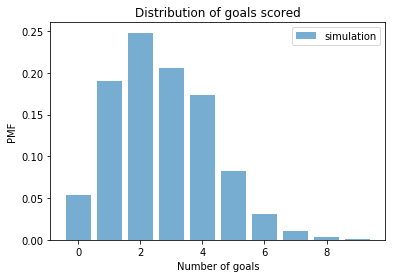

In [8]:
plot_pmf(sample_sim, label='simulation')
decorate_pmf_goals()

plt.savefig('zigzag1.png', dpi=150)

## Poisson process

For large values of `n`, the process we just simulated converges to the Poisson distribution with parameter `mu = n * p`, which is also `mu = lam_per_game`.

We can use NumPy to generate a sample from a Poisson distribution.

In [9]:
n = 60
p = lam_per_min
mu = n * p
sample_poisson = np.random.poisson(mu, size)
np.mean(sample_poisson)

2.733

And confirm that the results are similar to what we got from the model.

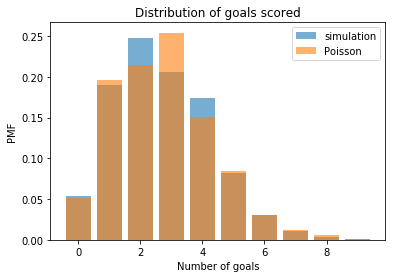

In [10]:
plot_pmf(sample_sim, label='simulation')
plot_pmf(sample_poisson, label='Poisson')
decorate_pmf_goals()

plt.savefig('zigzag2.png', dpi=150)

But plotting PMFs is a bad way to compare distributions.  It's better to use the cumulative distribution function (CDF).

In [11]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = Pmf(sample)
    xs, freqs = pmf.sorted_items()
    ps = np.cumsum(freqs, dtype=np.float)
    ps /= ps[-1]
    plot(xs, ps, **options)
    
def decorate_cdf_rates():
    """Decorate the axes."""
    plt.xlabel('Goal scoring rate (mu)')
    plt.ylabel('CDF')
    plt.title('Distribution of goal scoring rate')
    legend()

def decorate_cdf_goals():
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel('CDF')
    plt.title('Distribution of goals scored')
    legend()

def plot_cdfs(*sample_seq, **options):
    """Plot multiple CDFs."""
    for sample in sample_seq:
        plot_cdf(sample, **options)
    decorate_cdf_goals()

Comparing CDFs makes it clearer that the results from the simulation are consistent with the Poisson model.

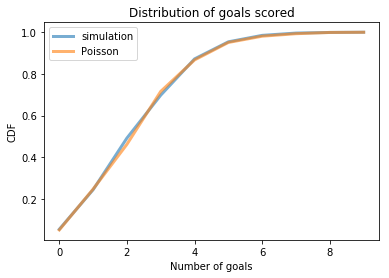

In [12]:
plot_cdf(sample_sim, label='simulation')
plot_cdf(sample_poisson, label='Poisson')
decorate_cdf_goals()

plt.savefig('zigzag3.png', dpi=150)

## Warming up PyMC

Soon we will want to use `pymc3` to do inference, which is really what it's for.  But just to get warmed up, I will use it to generate a sample from a Poisson distribution.

In [13]:
model = pm.Model()

with model:
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

In [14]:
len(trace['goals'])

1000

In [15]:
sample_pm = trace['goals']
np.mean(sample_pm)

2.634

This example is like using a cannon to kill a fly.  But it help us learn to use the cannon.

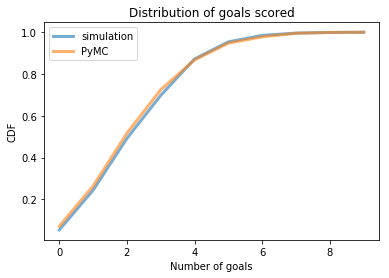

In [16]:
plot_cdf(sample_sim, label='simulation')
plot_cdf(sample_pm, label='PyMC')
decorate_cdf_goals()

## Evaluating the Poisson distribution

One of the nice things about the Poisson distribution is that we can compute its PMF analytically, and SciPy provides an implementation.

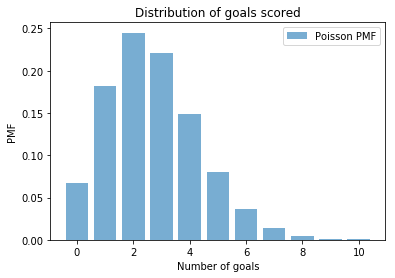

In [17]:
from scipy.stats import poisson

xs = np.arange(11)
ps = poisson.pmf(xs, mu)
bar(xs, ps, label='Poisson PMF')
decorate_pmf_goals()

And here's a function that computes the probability of scoring a given number of goals in a game, for a known value of `mu`.

In [18]:
def poisson_likelihood(goals, mu):
    """Probability of goals given scoring rate.
    
    goals: observed number of goals (scalar or sequence)
    mu: hypothetical goals per game
    
    returns: probability
    """
    return np.prod(poisson.pmf(goals, mu))

Here's the probability of scoring 6 goals in a game if the long-term rate is 2.7 goals per game.

In [19]:
poisson_likelihood(goals=6, mu=2.7)

0.036162211957124435

Here's the probability of scoring 3 goals.

In [20]:
poisson_likelihood(goals=3, mu=2.7)

0.22046768454274915

This function also works with a sequence of goals, so we can compute the probability of scoring 6 goals in the first game and 3 in the second.

In [21]:
poisson_likelihood(goals=[6, 3], mu=2.7)

0.007972599138131342

## Bayesian inference with grid approximation

Ok, it's finally time to do some inference!  The function we just wrote computes the likelihood of the data, given a hypothetical value of `mu`:

$\mathrm{Prob}~(x ~|~ \mu)$

But what we really want is the distribution of `mu`, given the data:

$\mathrm{Prob}~(\mu ~|~ x)$

If only there were some theorem that relates these probabilities!

The following class implements Bayes's theorem.

In [22]:
class Suite(Pmf):
    """Represents a set of hypotheses and their probabilities."""
    
    def bayes_update(self, data, like_func):
        """Perform a Bayesian update.
        
        data:      some representation of observed data
        like_func: likelihood function that takes (data, hypo), where
                   hypo is the hypothetical value of some parameter,
                   and returns P(data | hypo)
        """
        for hypo in self:
            self[hypo] *= like_func(data, hypo)
        self.normalize()
        
    def plot(self, **options):
        """Plot the hypotheses and their probabilities."""
        xs, ps = self.sorted_items()
        plot(xs, ps, **options)
        

def decorate_pdf_rate():
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel('PDF')
    plt.title('Distribution of goal scoring rate')
    legend()

I'll start with a uniform prior just to keep things simple.  We'll choose a better prior later.

In [23]:
hypo_mu = np.linspace(0, 15, num=51)
hypo_mu

array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ,
        3.3,  3.6,  3.9,  4.2,  4.5,  4.8,  5.1,  5.4,  5.7,  6. ,  6.3,
        6.6,  6.9,  7.2,  7.5,  7.8,  8.1,  8.4,  8.7,  9. ,  9.3,  9.6,
        9.9, 10.2, 10.5, 10.8, 11.1, 11.4, 11.7, 12. , 12.3, 12.6, 12.9,
       13.2, 13.5, 13.8, 14.1, 14.4, 14.7, 15. ])

Initially `uniform_prior` represents the prior distribution of `mu`.

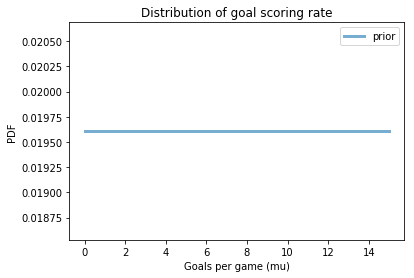

In [24]:
uniform_prior = Suite(hypo_mu)
uniform_prior.normalize()
uniform_prior.plot(label='prior')
decorate_pdf_rate()

plt.savefig('zigzag4.png', dpi=150)

Now we can update it with the data and plot the posterior.

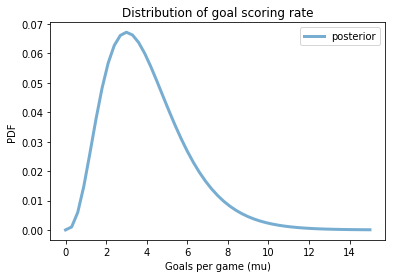

In [25]:
uniform_prior.bayes_update(data=3, like_func=poisson_likelihood)
uniform_prior.plot(label='posterior')
decorate_pdf_rate()

plt.savefig('zigzag5.png', dpi=150)

With a uniform prior, the posterior is the likelihood function, and the MAP is the value of `mu` that maximizes likelihood, which is the observed number of goals, 6.

This result is probably not reasonable, because the prior was not reasonable.

## A better prior

To construct a better prior, I'll use a Gamma distribution with parameters chosen to be consistent with previous playoff games.

We can use `make_gamma_dist` to construct a prior suite with the given parameters.

In [26]:
from scipy.stats import gamma

def make_gamma_suite(xs, alpha, beta):
    """Makes a suite based on a gamma distribution.
    
    xs: places to evaluate the PDF
    alpha, beta: parameters of the distribution
    
    returns: Suite
    """
    ps = gamma(a=alpha, scale=1/beta).pdf(xs)
    prior = Suite(dict(zip(xs, ps)))
    prior.normalize()
    return prior

Here's what it looks like.

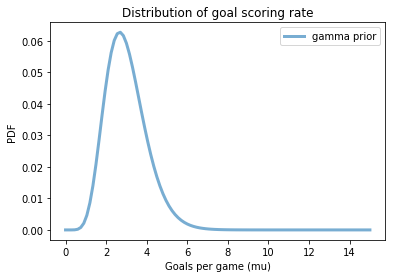

In [27]:
alpha = 9
beta = 3
hypo_mu = np.linspace(0, 15, num=101)

gamma_prior = make_gamma_suite(hypo_mu, alpha, beta)

gamma_prior.plot(label='gamma prior')
decorate_pdf_rate()

plt.savefig('zigzag6.png', dpi=150)

And we can update this prior using the observed data.  If we only score 1 goal in a game, our estimate for the goal scoring rate shifts left.

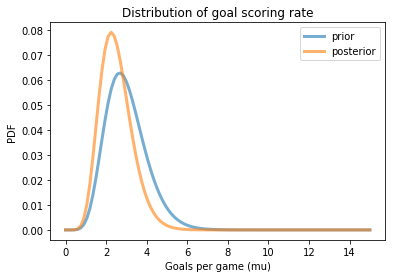

In [28]:
posterior = gamma_prior.copy()
posterior.bayes_update(data=1, like_func=poisson_likelihood)

gamma_prior.plot(label='prior')
posterior.plot(label='posterior')
decorate_pdf_rate()

plt.savefig('zigzag7.png', dpi=150)

If we go back to the original prior, and score 6 goals in a game, the estimate shifts to the right.

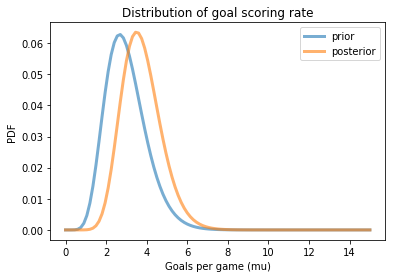

In [29]:
posterior = gamma_prior.copy()
posterior.bayes_update(data=6, like_func=poisson_likelihood)

gamma_prior.plot(label='prior')
posterior.plot(label='posterior')
decorate_pdf_rate()

plt.savefig('zigzag8.png', dpi=150)

If we score 3 goals in a game, the estimate doesn't shift much, but it gets pointier, which means we are more certain about the goal scoring rate.

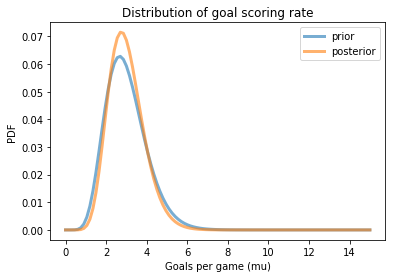

In [30]:
posterior = gamma_prior.copy()
posterior.bayes_update(data=3, like_func=poisson_likelihood)

gamma_prior.plot(label='prior')
posterior.plot(label='posterior')
decorate_pdf_rate()

plt.savefig('zigzag8.png', dpi=150)

## Posterior predictive distribution

Now, let's get to what is usually the point of this whole exercise, making predictions.

The prior represents what we believe about the distribution of `mu` based on the data (and our prior beliefs).

Each value of `mu` is a possible goal scoring rate.

For a given value of `mu`, we can generate a distribution of goals scored in a particular game, which is Poisson.

But we don't have a given value of `mu`, we have a whole bunch of values for `mu`, with different probabilities.

So the posterior predictive distribution is a mixture of Poissons with different parameters.

The simplest way to generate the posterior predictive distribution is to

1. Draw a random `mu` from the posterior distribution.

2. Draw a random number of goals from `Poisson(mu)`.

3. Repeat.

Here's a function that draws a sample from a posterior `Suite`:

In [31]:
def sample_suite(suite, size):
    """Draw a random sample from a Suite
    
    suite: Suite object
    size: sample size
    """
    xs, ps = np.transpose(list(suite.items()))
    return np.random.choice(xs, size, replace=True, p=ps)

Here's a sample of `mu` drawn from the posterior distribution (after one game).

In [32]:
size = 10000
sample_post = sample_suite(posterior, size)
np.mean(sample_post)

2.988255

Now for each value of `mu` in the posterior sample we draw one sample from `Poisson(mu)`

In [33]:
sample_post_pred = np.random.poisson(sample_post)
np.mean(sample_post_pred)

2.9984

The result is a sample from the posterior predictive distribution.  Here's what it looks like.

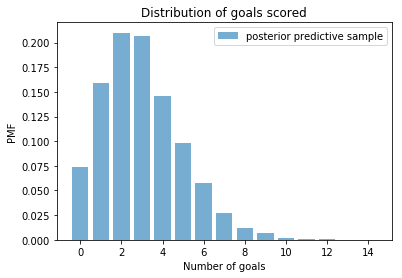

In [34]:
plot_pmf(sample_post_pred, label='posterior predictive sample')
decorate_pmf_goals()

plt.savefig('zigzag9.png', dpi=150)

The prior and posterior are distributions of mu, which is a continuous value.

The prior predictive and posterior predictive are distributions of goals, which are discrete.

To help keep them straight, I will plot distributions of mu as CDFs, and distributions of goals as PMFs.


## Back to PyMC

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from a gamma distribution of `mu`, with known `alpha` and `beta`.

And then use that value of `mu` to draw a sample from a Poisson distribution.

Here are the values of the parameters:

In [35]:
print(alpha, beta)

9 3


Here's what the model looks like:

In [36]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

The distribution of `mu` from this model is the prior.  Let's see what it looks like:

In [37]:
sample_prior_pm = trace['mu']
np.mean(sample_prior_pm)

2.9737837778840777

And compare it to a sample from the gamma prior.

In [38]:
sample_prior = sample_suite(gamma_prior, 1000)
np.mean(sample_prior)

2.9865

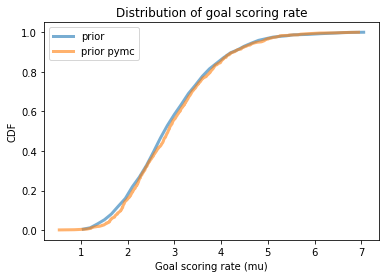

In [39]:
plot_cdf(sample_prior, label='prior')
plot_cdf(sample_prior_pm, label='prior pymc')
decorate_cdf_rates()

plt.savefig('zigzag10.png', dpi=150)

It looks pretty good.

The distributions of `goals` from this model is the prior predictive.

In [40]:
sample_prior_pred_pm = trace['goals']
np.mean(sample_prior_pred_pm)

2.965

And let's compare it to a prior predictive distribution estimated by sampling.

In [41]:
sample_prior_pred = np.random.poisson(sample_prior)
np.mean(sample_prior_pred)

2.971

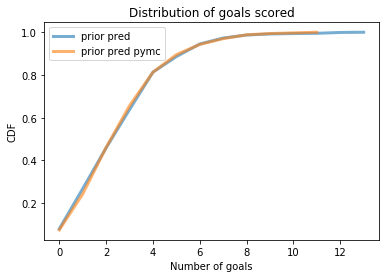

In [42]:
plot_cdf(sample_prior_pred, label='prior pred')
plot_cdf(sample_prior_pred_pm, label='prior pred pymc')
decorate_cdf_goals()

plt.savefig('zigzag11.png', dpi=150)

Looks good.

## Now with PyMC

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `3`.

And instead of called `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [43]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=3)
    trace = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3506.74draws/s]
The acceptance probability does not match the target. It is 0.6927188582727735, but should be close to 0.8. Try to increase the number of tuning steps.


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  We can plot the posterior using a function provided by PyMC:

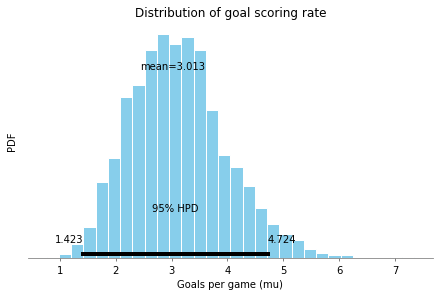

In [44]:
pm.plot_posterior(trace)
decorate_pdf_rate()

And we can extract a sample from the posterior of `mu`

In [45]:
sample_post_pm = trace['mu']
np.mean(sample_post_pm)

3.0131639332686024

And compare it to the sample we drew from the grid approximation:

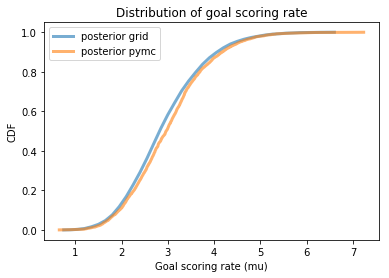

In [46]:
plot_cdf(sample_post, label='posterior grid')
plot_cdf(sample_post_pm, label='posterior pymc')
decorate_cdf_rates()

plt.savefig('zigzag12.png', dpi=150)

Again, it looks pretty good.

To sample from the posterior predictive distribution, we can use `sample_posterior_predictive`:

In [47]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 2746.40it/s]


Here's what it looks like:

In [48]:
sample_post_pred_pm = post_pred['goals']
sample_post_pred_pm.shape

(1000,)

In [49]:
sample_post_pred_pm = post_pred['goals']
np.mean(sample_post_pred_pm)

3.092

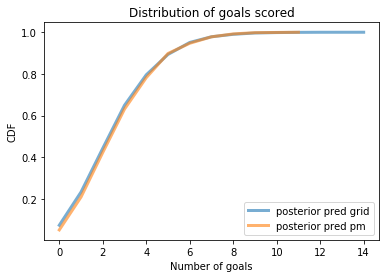

In [50]:
plot_cdf(sample_post_pred, label='posterior pred grid')
plot_cdf(sample_post_pred_pm, label='posterior pred pm')
decorate_cdf_goals()

plt.savefig('zigzag13.png', dpi=150)

Looks pretty good!

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [51]:
model = pm.Model()

with model:
    mu_BOS = pm.Gamma('mu_BOS', alpha, beta)
    mu_ANA = pm.Gamma('mu_ANA', alpha, beta)
    goals_BOS = pm.Poisson('goals_BOS', mu_BOS, observed=3)
    goals_ANA = pm.Poisson('goals_ANA', mu_ANA, observed=1)
    trace = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ANA, mu_BOS]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3790.51draws/s]


We can use `traceplot` to review the results and do some visual diagnostics.

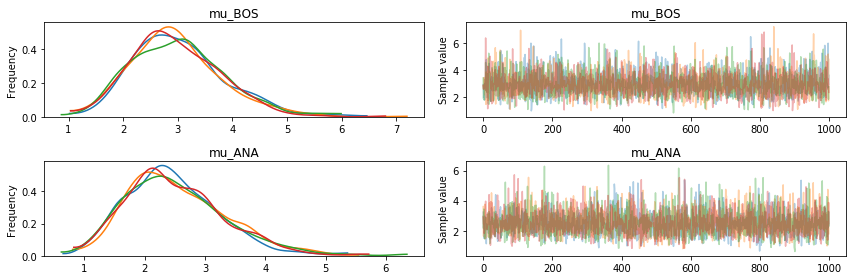

In [52]:
pm.traceplot(trace);

Here are the posterior distribitions for `mu_BOS` and `mu_ANA`.

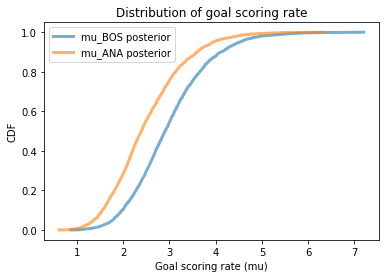

In [53]:
mu_BOS = trace['mu_BOS']
plot_cdf(mu_BOS, label='mu_BOS posterior')

mu_ANA = trace['mu_ANA']
plot_cdf(mu_ANA, label='mu_ANA posterior')

decorate_cdf_rates()
np.mean(mu_BOS), np.mean(mu_ANA)

plt.savefig('zigzag14.png', dpi=150)

On the basis of one game here's the probability that Boston is the better team.

In [54]:
np.mean(mu_BOS > mu_ANA)

0.66725

In [55]:
np.mean(mu_BOS == mu_ANA)

0.0

## Predictions

Even if Boston is the better team, that doesn't mean they'll win the next game.

We can use `sample_posterior_predictive` to generate predictions.

In [56]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1386.94it/s]


Here are the posterior predictive distributions of goals scored.

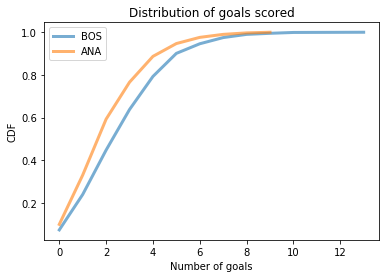

In [57]:
goals_BOS = post_pred['goals_BOS'].flatten()
goals_ANA = post_pred['goals_ANA'].flatten()

plot_cdf(goals_BOS, label='BOS')
plot_cdf(goals_ANA, label='ANA')
decorate_cdf_goals()

plt.savefig('zigzag15.png', dpi=150)

Here's the chance that Boston wins the next game.

In [58]:
win = np.mean(goals_BOS > goals_ANA)
win

0.513

The chance that they lose.

In [59]:
lose = np.mean(goals_ANA > goals_BOS)
lose

0.335

And the chance of a tie.

In [60]:
tie = np.mean(goals_BOS == goals_ANA)
tie

0.152

## Overtime!

In the event of a tie, the teams play a five-minute overtime period during which the team that scores first wins.

In a Poisson process with rate parameter `mu`, the time until the next event is exponential with parameter `lam = 1/mu`.

So we can take a sample from the posterior distributions of `mu`:

In [61]:
mu_ANA = trace['mu_ANA']
mu_BOS = trace['mu_BOS']

array([2.94596135, 2.56428703, 2.02257676, ..., 3.16156756, 3.00181319,
       2.37807074])

And generate time to score,`tts`, for each team:

In [62]:
tts_ANA  = np.random.exponential(1/mu_ANA)
np.mean(tts_ANA)

0.4452535794803446

In [63]:
tts_BOS  = np.random.exponential(1/mu_BOS)
np.mean(tts_BOS)

0.35965728049629286

Here's the chance that Boston wins in overtime.

In [64]:
win_ot = np.mean(tts_BOS < tts_ANA)
win_ot

0.5475

Since `tts` is continuous, ties are unlikely.

In [65]:
total_win = win + tie * win_ot
total_win

0.59622